In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

In [4]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
print(train.shape)
print(test.shape)

(54808, 14)
(23490, 13)


In [6]:
# Learning rate
print("Event rate in %: ", round((train["is_promoted"].value_counts()[1] * 100)/train.shape[0], 2))
# 8.52 - We may have to try SMOTE here. Lets see further

Event rate in %:  8.52


In [7]:
print(train.describe())

        employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min    

In [8]:
# Any missing variables
train.count()
# education               52399               
# previous_year_rating    50684

employee_id             54808
department              54808
region                  54808
education               52399
gender                  54808
recruitment_channel     54808
no_of_trainings         54808
age                     54808
previous_year_rating    50684
length_of_service       54808
KPIs_met >80%           54808
awards_won?             54808
avg_training_score      54808
is_promoted             54808
dtype: int64

In [9]:
print(train['education'].value_counts())
print(train['previous_year_rating'].value_counts())

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64


In [10]:
values = {"previous_year_rating":3, "education":"Bachelor's"}
train.fillna(value=values, inplace=True)

In [11]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [12]:
train.groupby("previous_year_rating")['is_promoted'].value_counts().unstack()

is_promoted,0,1
previous_year_rating,,
1.0,6135,88
2.0,4044,181
3.0,21048,1694
4.0,9093,784
5.0,9820,1921


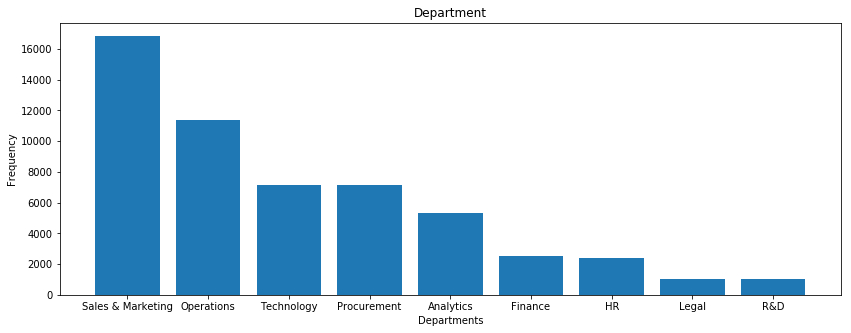

In [13]:
# Let do some plotting
#train.ftypes
department_count = train["department"].value_counts()
plt.figure(figsize=(14,5))
plt.bar(department_count.index, department_count.values)
plt.xlabel("Departments")
plt.ylabel("Frequency")
plt.title("Department")
plt.show()

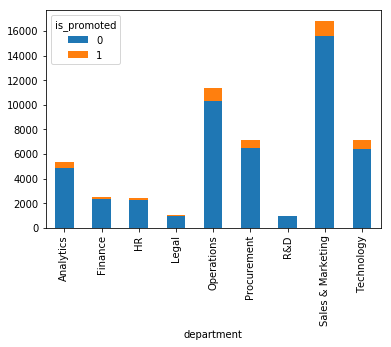

In [14]:
depart_count = train.groupby(["department", "is_promoted"])["is_promoted"].count()
depart_count.unstack().plot(kind='bar', stacked=True)

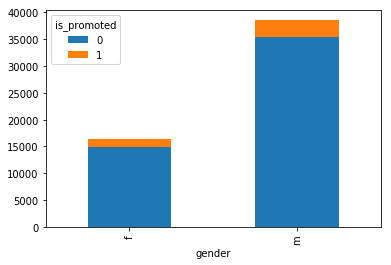

In [15]:
depart_count = train.groupby(["gender", "is_promoted"])["is_promoted"].count()
depart_count.unstack().plot(kind='bar', stacked=True)

In [16]:
# EDA
for col in train.drop('is_promoted', axis=1).columns:
    if train[col].dtype == 'object':
        xx = train.groupby(col)['is_promoted'].value_counts().unstack()
        per_not_promoted = xx.iloc[:, 0] *100/xx.apply(lambda x: x.sum(), axis=1)
        per_promoted = xx.iloc[:, 1]*100/xx.apply(lambda x: x.sum(), axis=1)
        xx['%_0'] = round(per_not_promoted,2)
        xx['%_1'] = round(per_promoted,2)
        display(xx)

is_promoted,0,1,%_0,%_1
department,,,,
Analytics,4840,512,90.43,9.57
Finance,2330,206,91.88,8.12
HR,2282,136,94.38,5.62
Legal,986,53,94.90,5.10
Operations,10325,1023,90.99,9.01
Procurement,6450,688,90.36,9.64
R&D,930,69,93.09,6.91
Sales & Marketing,15627,1213,92.80,7.20
Technology,6370,768,89.24,10.76


is_promoted,0,1,%_0,%_1
region,,,,
region_1,552,58,90.49,9.51
region_10,597,51,92.13,7.87
region_11,1241,74,94.37,5.63
region_12,467,33,93.40,6.60
region_13,2418,230,91.31,8.69
region_14,765,62,92.50,7.50
region_15,2586,222,92.09,7.91
region_16,1363,102,93.04,6.96
region_17,687,109,86.31,13.69


is_promoted,0,1,%_0,%_1
education,,,,
Bachelor's,35948,3130,91.99,8.01
Below Secondary,738,67,91.68,8.32
Master's & above,13454,1471,90.14,9.86


is_promoted,0,1,%_0,%_1
gender,,,,
f,14845,1467,91.01,8.99
m,35295,3201,91.68,8.32


is_promoted,0,1,%_0,%_1
recruitment_channel,,,,
other,27890,2556,91.60,8.40
referred,1004,138,87.92,12.08
sourcing,21246,1974,91.50,8.50


In [17]:
# Convert categorical to dummies
def convert_categorical_to_dummies(df):
    list_to_drop = []
    for col in df.columns:
        if df[col].dtype == 'object':
            print("Converting....", col)
            list_to_drop.append(col)
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    return df, list_to_drop

In [ ]:
train.head()

In [ ]:
# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(train)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

train_xs = processed_data.drop(['employee_id',"is_promoted"],axis=1)
labels = train["is_promoted"]

In [ ]:
# Build Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)
import graphviz

In [ ]:
# XGBOOST
xgb_model = xgb.XGBClassifier()
print(xgb_model)

f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1')
print("F1-score = ",f1_scores," Mean F1 score = ", np.mean(f1_scores))

In [ ]:
# Training the models
xgb_model.fit(train_xs, labels)

In [ ]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [900, 1000, 1100],
     'max_depth':[7,8,9],
     'reg_alpha':[0.3, 0.4, 0.5]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)
 
# Cross validation scores
f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1',n_jobs=2)
print("F1_scores per fold : ",f1_scores," \nMean F1_score= ", np.mean(f1_scores))
 
# Fitting model on tuned parameters
xgb_model.fit(train_xs, labels)

In [ ]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)

f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

In [ ]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

In [ ]:
# Create submission file
test = pd.read_csv("dataset/test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

# Best model as of now

In [ ]:
#predictions = (y_pred[:,1] >= scrs.f1_score.max()).astype("int") # 0.47025495750708224.
#predictions = (y_pred[:,1] >= 0.340377241373).astype("int") # 0.4876760563380282 
predictions = (y_pred[:,1] >= 0.24252495169639587).astype("int") # 0.5158371040723982.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("XGB_tuned_model_1.csv", index=False)

In [ ]:
# Try lightgbm
# Initializing the LightGBM model
gbm_model = lgb.LGBMClassifier(objective='binary')

# Cross validation score 
f1_scores = cross_val_score(gbm_model, train_xs, labels, cv=5, scoring='f1',n_jobs=3)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)

# Fitting LightGBM model
gbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=150)

In [ ]:
# Create submission file
test = pd.read_csv("dataset/test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = gbm_model.predict_proba(test_data, num_iteration=gbm_model.best_iteration_)

In [ ]:
predictions = (y_pred[:,1] >= 0.24252495169639587).astype("int") # 0.4996009577015163
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("lgbm_model_2.csv", index=False) 

In [ ]:
ratio = float(np.sum(labels == 0)) / np.sum(labels==1)
print(ratio)

# Try Model with solving the imbalancing problem.....No Smote as of now. Will try class weight

In [ ]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [800, 900, 1000, 1100],
     'max_depth':[5, 6, 7, 8, 9],
     'reg_alpha':[0.2, 0.3, 0.4, 0.5, 0.6],
     'scale_pos_weight': [ratio]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=-1)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)
 
# Cross validation scores
f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1',n_jobs=2)
print("F1_scores per fold : ",f1_scores," \nMean F1_score= ", np.mean(f1_scores))
 
# Fitting model on tuned parameters
xgb_model.fit(train_xs, labels)

In [ ]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)

f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

In [ ]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

# Create submission file
test = pd.read_csv("dataset/test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

In [ ]:
predictions = (y_pred[:,1] >= 0.7739043235778809).astype("int") # 0.42322834645669294.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("xgb_weightfactor.csv", index=False) 

In [ ]:
# No Improvement. Lets try SMOTE

from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_xs, labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

In [ ]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [800, 900, 1000, 1100],
     'max_depth':[5, 6, 7, 8, 9],
     'reg_alpha':[0.2, 0.3, 0.4, 0.5, 0.6]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=-1)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)
 
# Cross validation scores
f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1',n_jobs=2)
print("F1_scores per fold : ",f1_scores," \nMean F1_score= ", np.mean(f1_scores))
 
# Fitting model on tuned parameters
xgb_model.fit(X_train_res, y_train_res)

In [ ]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)

f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

In [ ]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

# Create submission file
test = pd.read_csv("dataset/test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

In [ ]:
predictions = (y_pred[:,1] >= 0.30655303597450256).astype("int") # 0.4995722840034217.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("smote_xgb_weightfactor.csv", index=False) 

In [18]:
# Not improving at all. Best solution comes with XGBoost. Will now try to create new features.
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [25]:
train = pd.read_csv("dataset/train.csv")

In [26]:
values = {"previous_year_rating":3, "education":"Bachelor's"}
train.fillna(value=values, inplace=True)

In [27]:
#dep_mean_score = round(train.groupby(["department"], as_index=False)["avg_training_score"].mean())
#reg_mean_score = round(train.groupby(["region"], as_index=False)["avg_training_score"].mean())

In [28]:
# Feature 1 - It make more senese to promote deparmment wise if average score is higher.
dep_mean_score = round(train.groupby(["department"], as_index=False)["avg_training_score"].mean())
train = pd.merge(train, dep_mean_score, on = "department", how='inner',suffixes=("", "_bydep"))

In [29]:
# Feature 2 - average_score_by region
reg_mean_score = round(train.groupby(["region"], as_index=False)["avg_training_score"].mean())
train = pd.merge(train, reg_mean_score, on = "region", how='inner',suffixes=("", "_byregion"))

In [30]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,avg_training_score_bydep,avg_training_score_byregion
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,50.0,64.0
1,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,50.0,64.0
2,35465,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,24,1.0,2,0,0,48,0,50.0,64.0
3,47123,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,40,5.0,3,0,0,47,0,50.0,64.0
4,77577,Sales & Marketing,region_7,Bachelor's,m,other,1,50,3.0,14,0,0,52,0,50.0,64.0


In [31]:
# Feature 3 & 4 avg training score is high
train["avg_training_score_bydep_high"] = (train["avg_training_score_bydep"] <= train["avg_training_score"]).astype(int)
train["avg_training_score_byregion_high"] = (train["avg_training_score_byregion"] <= train["avg_training_score"]).astype(int)

In [32]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,avg_training_score_bydep,avg_training_score_byregion,avg_training_score_bydep_high,avg_training_score_byregion_high
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,50.0,64.0,0,0
1,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,1,0,50,1,50.0,64.0,1,0
2,35465,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,24,1.0,2,0,0,48,0,50.0,64.0,0,0
3,47123,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,40,5.0,3,0,0,47,0,50.0,64.0,0,0
4,77577,Sales & Marketing,region_7,Bachelor's,m,other,1,50,3.0,14,0,0,52,0,50.0,64.0,1,0


In [33]:
# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(train)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

train_xs = processed_data.drop(['employee_id',"is_promoted"],axis=1)
labels = train["is_promoted"]

Converting.... department
Converting.... region
Converting.... education
Converting.... gender
Converting.... recruitment_channel
Total shape of Data : (54808, 64)
Columns which need to be dropped : ['department', 'region', 'education', 'gender', 'recruitment_channel']
Total shape of Data : (54808, 59)


In [ ]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [900, 1000, 1100],
     'max_depth':[7,8,9],
     'reg_alpha':[0.3, 0.4, 0.5]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)
 
# Cross validation scores
f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1',n_jobs=2)
print("F1_scores per fold : ",f1_scores," \nMean F1_score= ", np.mean(f1_scores))
 
# Fitting model on tuned parameters
xgb_model.fit(train_xs, labels)

In [ ]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)

f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

In [ ]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

In [ ]:
# Create submission file
test = pd.read_csv("dataset/test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

test.head()

In [ ]:
# Feature 1 & 2 - average_score_by region
test = pd.merge(test, dep_mean_score, on = "department", how='inner',suffixes=("", "_bydep"))
test = pd.merge(test, reg_mean_score, on = "region", how='inner',suffixes=("", "_byregion"))

# Feature 3 & 4 avg training score is high
test["avg_training_score_bydep_high"] = (test["avg_training_score_bydep"] <= test["avg_training_score"]).astype(int)
test["avg_training_score_byregion_high"] = (test["avg_training_score_byregion"] <= test["avg_training_score"]).astype(int)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

In [ ]:
predictions = (y_pred[:,1] >= 0.29761573672294617).astype("int") # 0.5050675675675677.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("feature_xgb_weightfactor.csv", index=False)